# Experiment Analysis: Controller parameter stability during shocks
Perform shocks of OCEAN price to test controller parameter stability, without stochastic processes.


# Setup and Dependencies

In [1]:
# Set project root folder, to enable importing project files from subdirectories
from pathlib import Path
import os
import datetime

path = Path().resolve()
root_path = str(path).split('notebooks')[0]
os.chdir(root_path)

In [2]:
# Import all shared dependencies and setup
from shared import *

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = "png"
png_renderer = pio.renderers["png"]
png_renderer.width = 1000
png_renderer.height = 600
from pprint import pprint

from models.system_model_v3.model.params.init import params
from models.system_model_v3.model.state_variables.init import state_variables
from experiments.system_model_v3.configure import generate_params
from experiments.system_model_v3.run import run_experiment

In [3]:
# Update dataframe display settings
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [4]:
SIMULATION_TIMESTEPS = 24 * 30 * 2 # Two month horizon for shock tests
MONTE_CARLO_RUNS = 5 # In this notebook, each run is mapped to a different shock

kp_sweep = [5e-8, 7.5e-8]
# ki_sweep = [5e-15, 1e-14, 5e-14,1e-13]

sweeps = {
    'kp': kp_sweep,
    # 'ki': ki_sweep,
}

params_update = generate_params(sweeps)
params.update(params_update)

In [5]:
# Override eth_price to create specific shocks
params_override = {
    'liquidation_ratio': [1.45],
    'eth_price': [lambda run, timestep, df=None: [
        # Shocks at 14 days; controller turns on at 7 days
        300, # no shock baseline
        300 if timestep < 24 * 14 else 300 * 1.3, # 30% step, remains for rest of simulation
        300 * 1.3 if timestep in list(range(24*14, 24*14 + 6, 1)) else 300, # 30% impulse for 6 hours
        300 if timestep < 24 * 14 else 300 * 0.7, # negative 30% step, remains for rest of simulation
        300 * 0.7 if timestep in list(range(24*14, 24*14 + 6, 1)) else 300, # negative 30% impulse for 6 hours
    ][run - 1]]
}
params.update(params_override)

In [6]:
df_raw = run_experiment(timesteps=SIMULATION_TIMESTEPS, runs=MONTE_CARLO_RUNS, params=params, initial_state=state_variables)

# Post Process Results

In [7]:
from experiments.system_model_v3.post_process import post_process_results

Remove substeps, add `set_params` to dataframe, and add post-processing columns:

In [8]:
df = post_process_results(df_raw, params)

# Shock Analysis

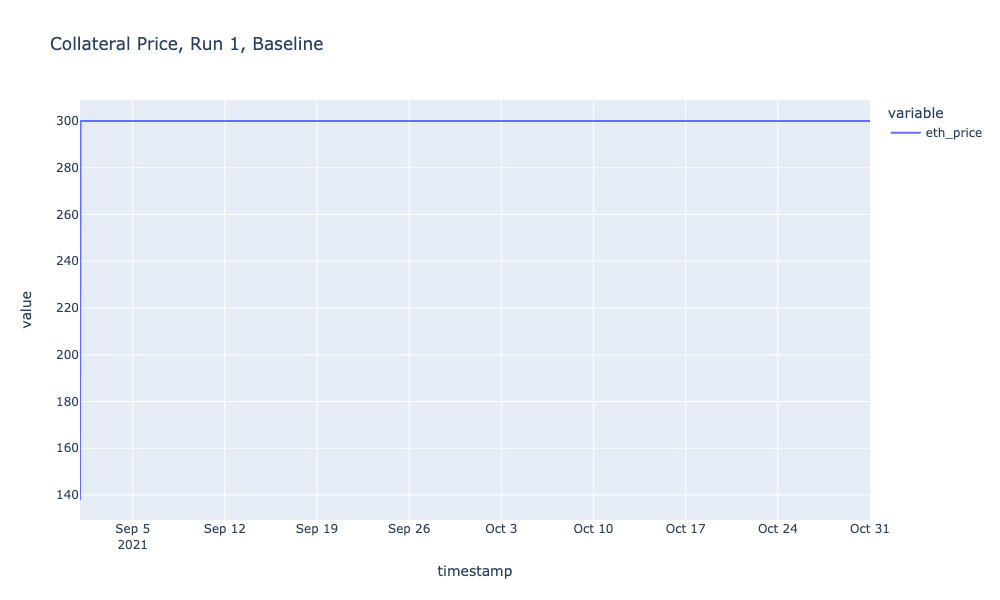

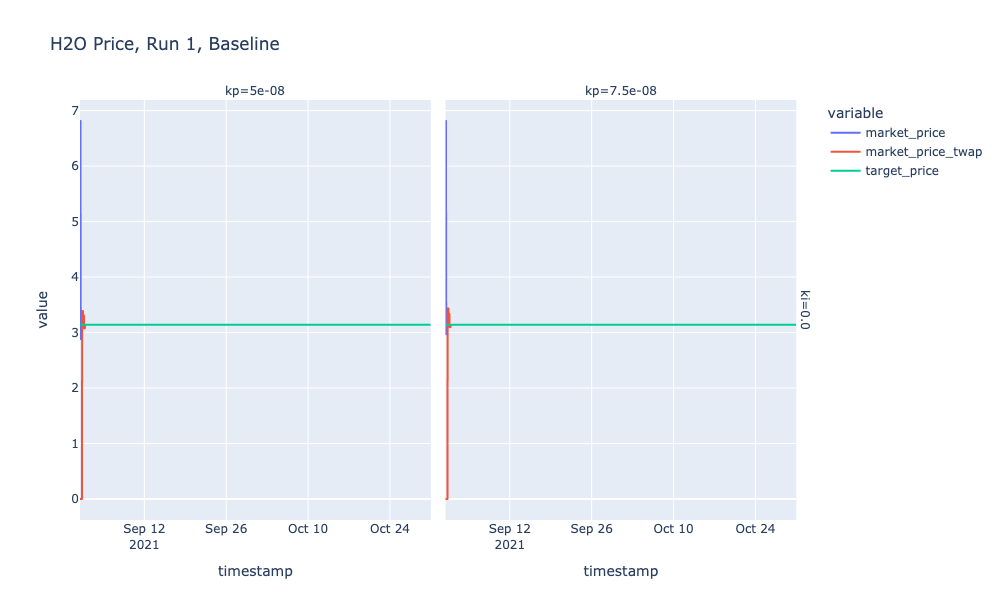

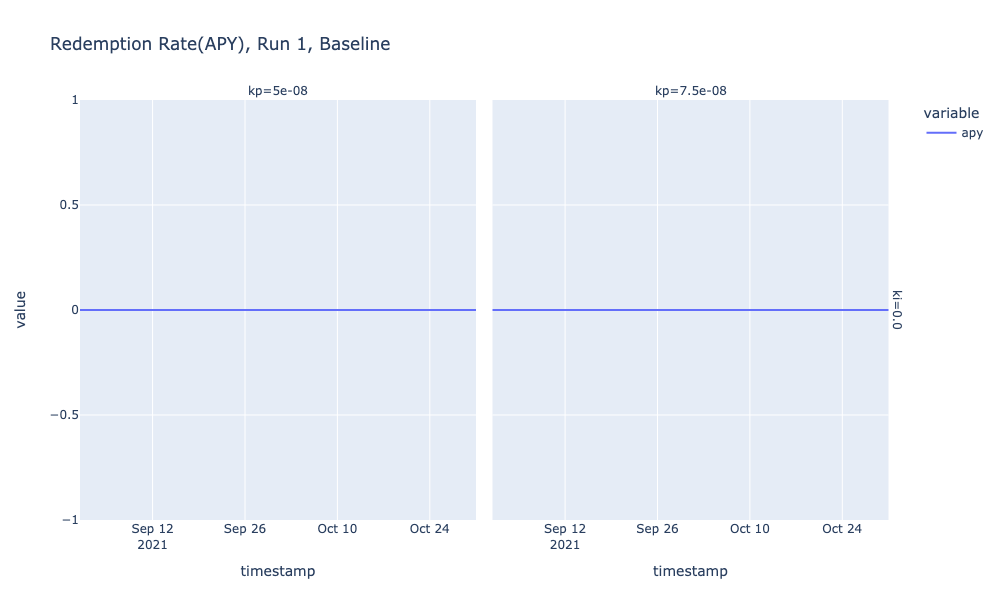

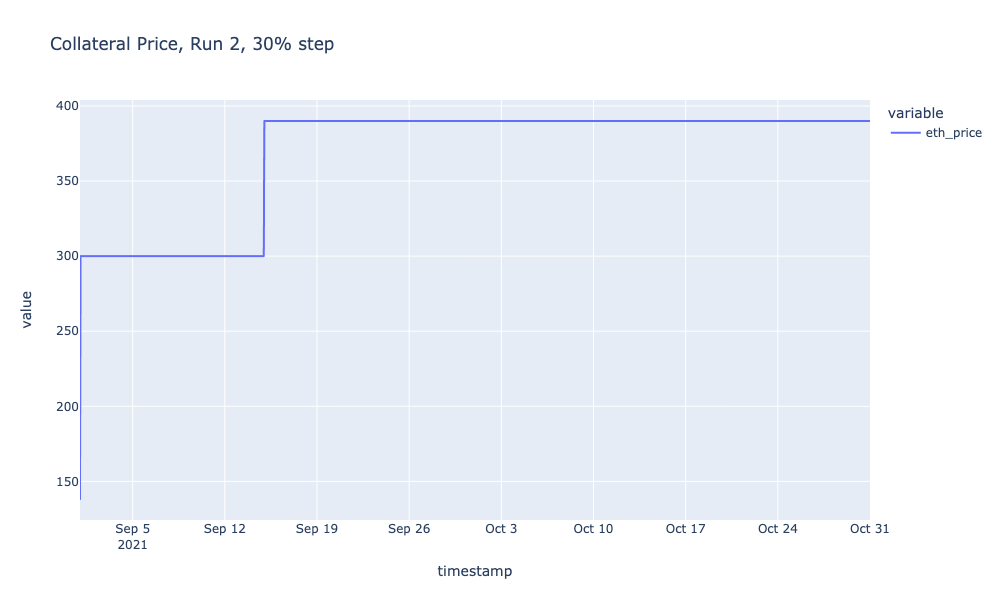

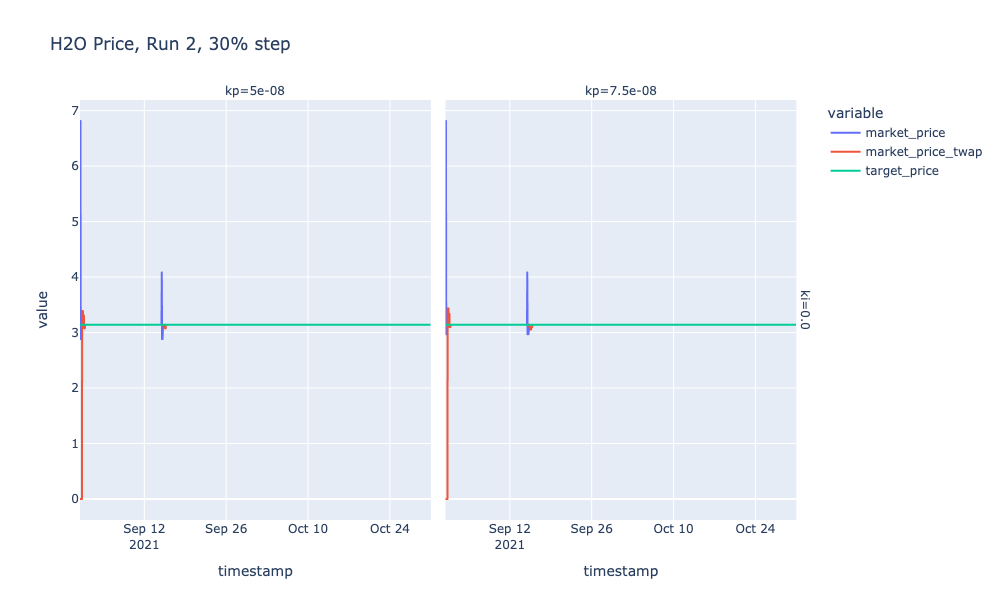

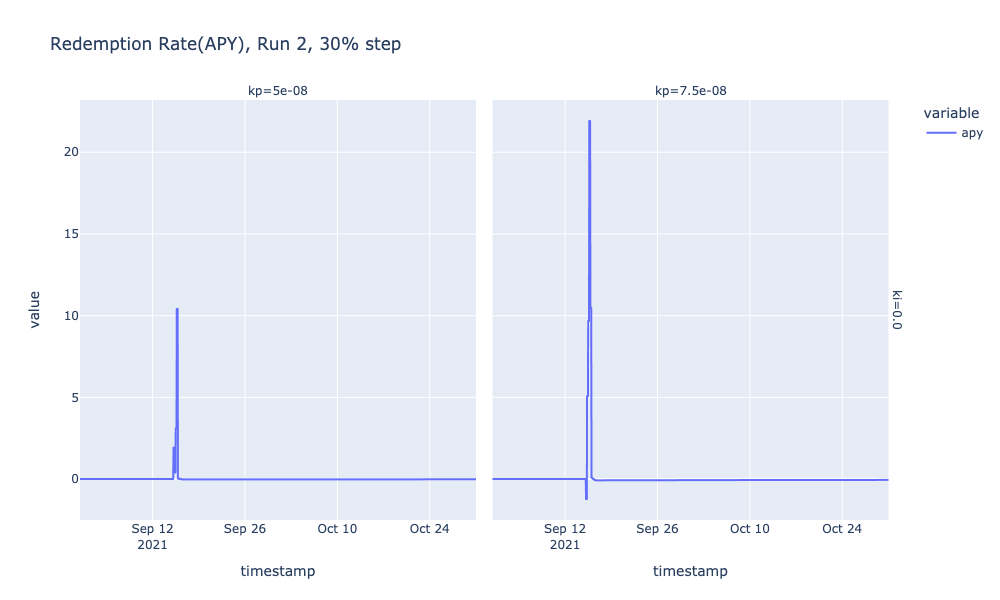

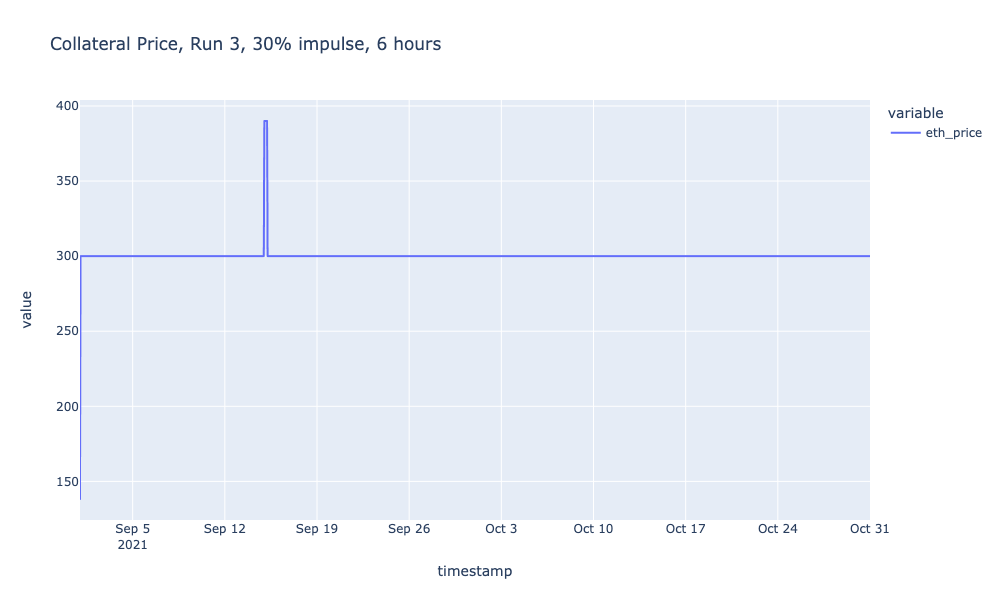

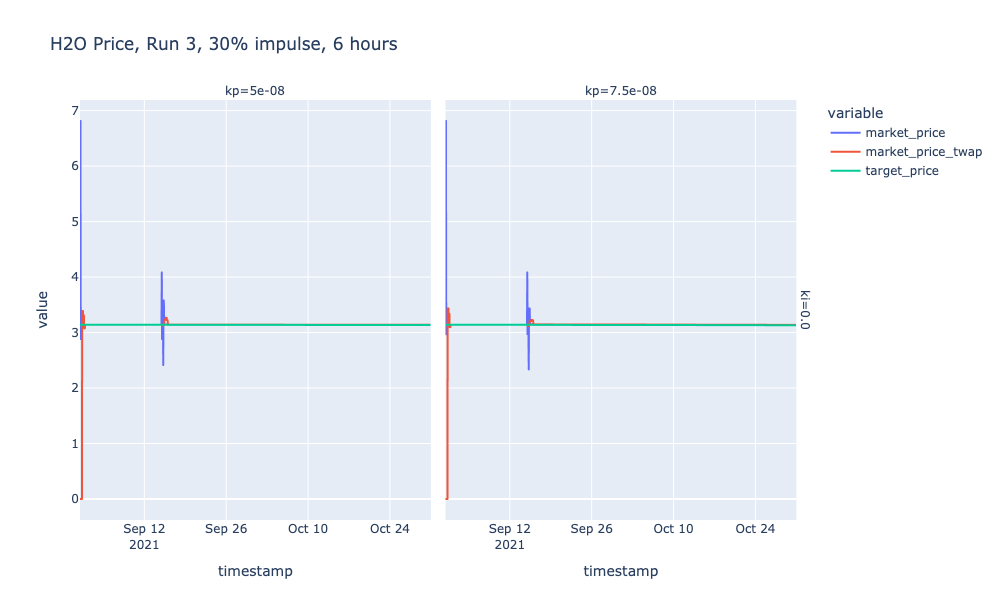

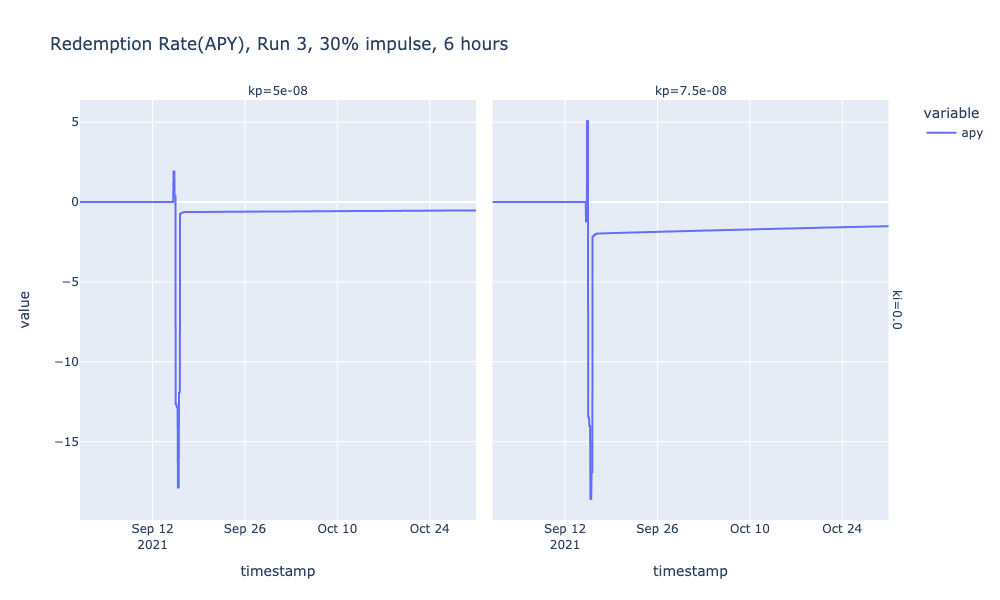

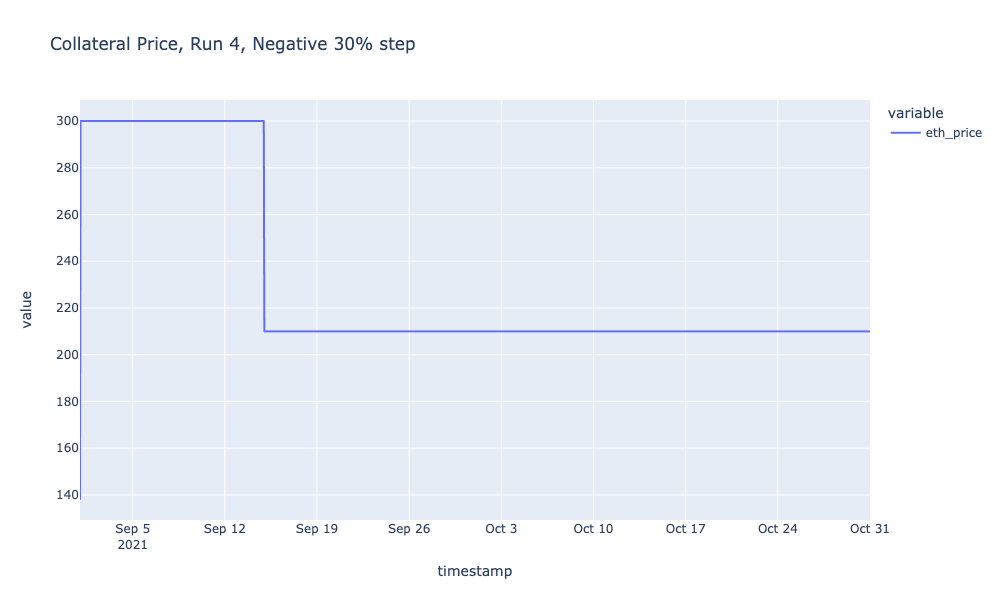

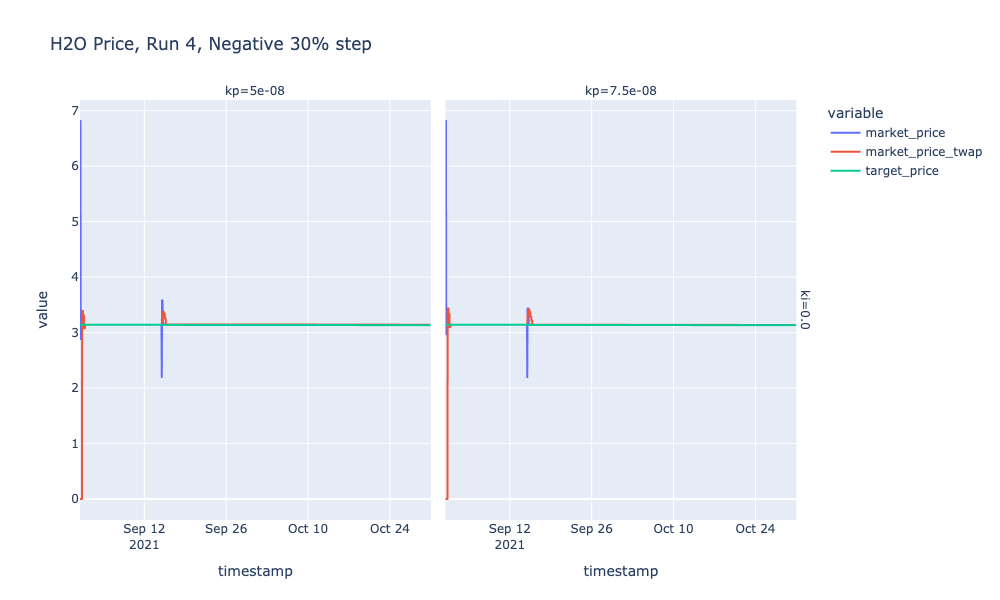

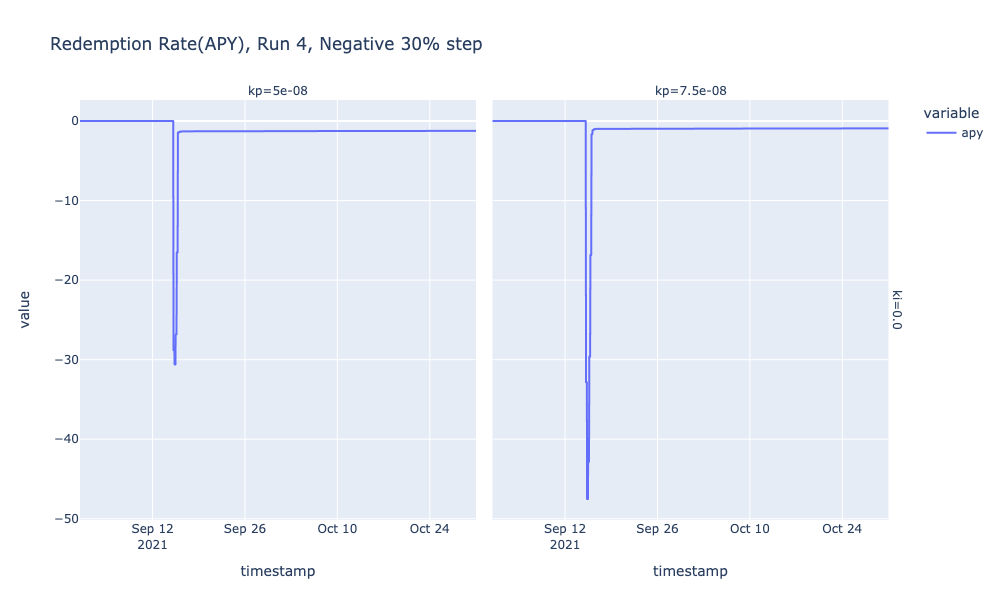

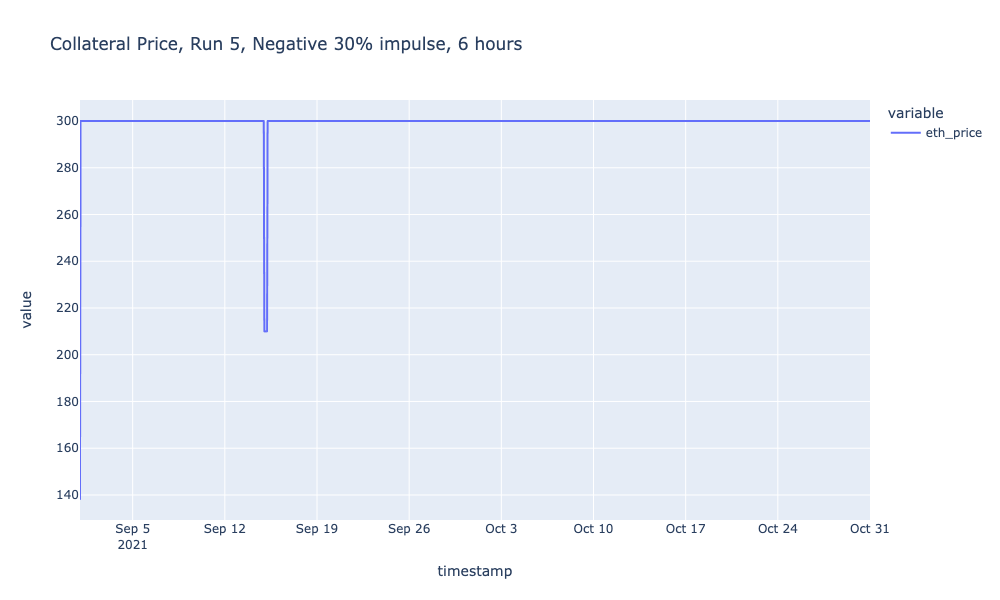

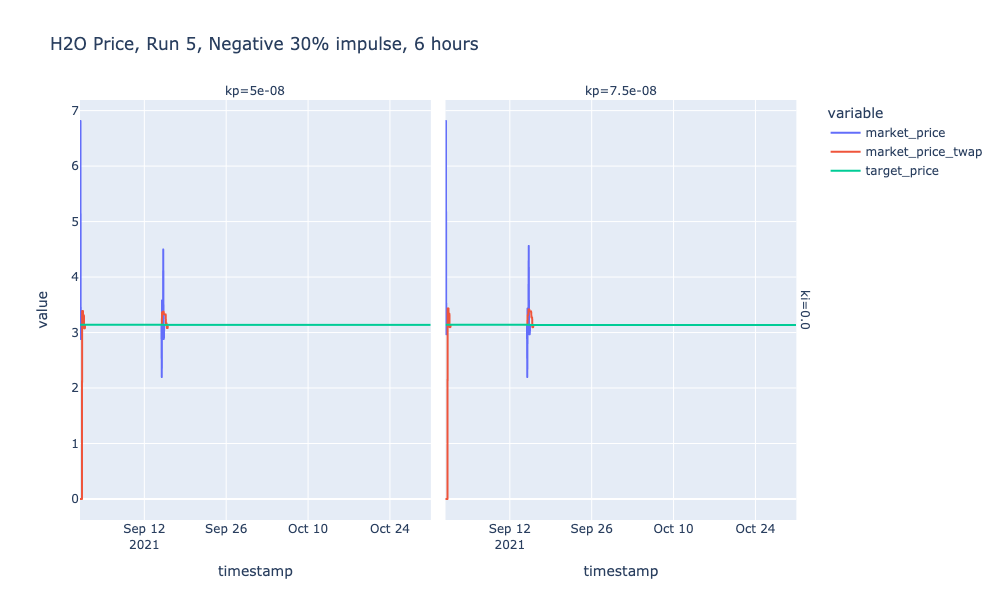

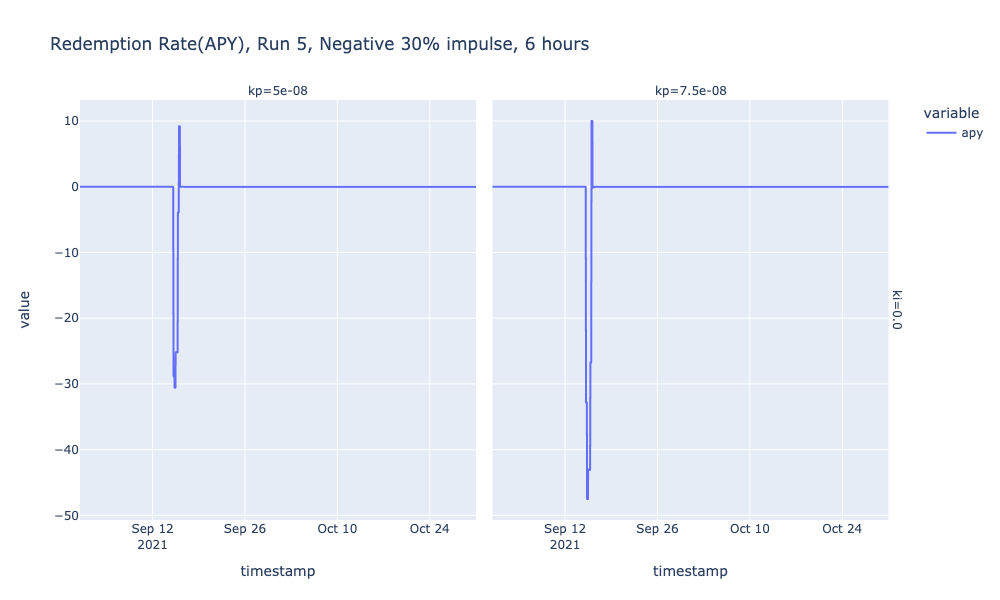

In [9]:
titles = {1: 'Baseline',
          2: '30% step',
          3: '30% impulse, 6 hours',
          4: 'Negative 30% step',
          5: 'Negative 30% impulse, 6 hours'
         }

for i in range(1, 6):
    fig = px.line(
        df.query(f'subset == 0 &run == {i}')[['timestamp', 'eth_price', 'run']],
        title=f"Collateral Price, Run {i}, {titles[i]}",
        x="timestamp",
        y=["eth_price"]
    )
    fig.show()
    fig = px.line(
        df.query(f'run == {i}'),
        title=f"H2O Price, Run {i}, {titles[i]}",
        x="timestamp",
        y=["market_price", "market_price_twap", "target_price"],
        facet_col="kp",
        facet_row="ki"
    )
    fig.show()
    fig = px.line(
        df.query(f'run == {i}'),
        title=f"Redemption Rate(APY), Run {i}, {titles[i]}",
        x="timestamp",
        y=["apy"],
        facet_col="kp",
        facet_row="ki"
    )
    fig.show()